In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [2]:
file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
diagType = 'ocean_cobalt_omip_2d'

years = ['0481-0485', '0486-0490', '0491-0495', '0496-0500']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [3]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
monthly_file_prefix = os.path.join(file_path, diagType, 'av', 'monthly_5yr/')
monthly_files = [dot.join([monthly_file_prefix + diagType, yy, mm, 'nc']) for yy in years for mm in months]
#print(monthly_files)

annual_file_prefix = os.path.join(file_path, diagType, 'av', 'annual_5yr/')
annual_files = [dot.join([annual_file_prefix + diagType, yy, 'ann', 'nc']) for yy in years]
#print(annual_files)

In [4]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

In [5]:
# monthly 
dsm = xr.open_mfdataset(monthly_files, combine='by_coords')

# annual
dsa = xr.open_mfdataset(annual_files, combine='by_coords')

In [6]:
# create climatology
dsm = dsm.groupby('time.month').mean(dim='time')

# create annual mean
dsa = dsa.mean(dim='time')

# Calculate Nutrient Limitation

In [7]:
days_in_mon = xr.DataArray([31,28,31,30,31,30,31,31,30,31,30,31], coords={'month':dsm.month}, dims='month')

In [8]:
intppdiat = dsm.intppdiat #units of mol C m-2 s-1
intppmisc = dsm.intppmisc
intpppico = dsm.intpppico

limnpico = dsm.limnpico
limppico = dsm.limppico
limfepico = dsm.limfepico

limndiat = dsm.limndiat
limpdiat = dsm.limpdiat
limfediat = dsm.limfediat

limnmisc = dsm.limnmisc
limpmisc = dsm.limpmisc
limfemisc = dsm.limfemisc

In [9]:
nlim_weighted_month = (intppdiat*limndiat + intppmisc*limnmisc + intpppico*limnpico)/\
                            (intppdiat + intppmisc + intpppico)

plim_weighted_month = (intppdiat*limpdiat + intppmisc*limpmisc + intpppico*limppico)/\
                            (intppdiat + intppmisc + intpppico);

felim_weighted_month = (intppdiat*limfediat + intppmisc*limfemisc + intpppico*limfepico)/\
                            (intppdiat + intppmisc + intpppico);

pp_by_month = (intppdiat + intpppico + intppmisc)*86400*days_in_mon*12*6.625 # convert to g N m-2 month-1

In [10]:
# # quick sanity check - this should be roughly 5e16
# (pp_by_month * grid.areacello / 6.625).sum().values

In [11]:
# Monthly weighted mean
nlim_weighted = (nlim_weighted_month * pp_by_month).sum(dim='month') / pp_by_month.sum(dim='month')
plim_weighted = (plim_weighted_month * pp_by_month).sum(dim='month') / pp_by_month.sum(dim='month')
felim_weighted = (felim_weighted_month * pp_by_month).sum(dim='month') / pp_by_month.sum(dim='month')

In [12]:
# calculate nutrient limitation by the liebig law
liebig_macro = np.min(np.stack((nlim_weighted,plim_weighted)),axis=0)
liebig = np.min(np.stack((liebig_macro,felim_weighted)),axis=0)

In [13]:
# compute whether limitation is weak or strong by subtracting out the degree of limitation from the other nutrients
aa = ~np.isfinite(felim_weighted)

felim = felim_weighted.values - np.min(np.stack((nlim_weighted.values,plim_weighted.values)),axis=0)
felim[aa] = np.nan
nlim  = nlim_weighted.values  - np.min(np.stack((felim_weighted.values,plim_weighted.values)),axis=0)
nlim[aa] = np.nan
plim  = plim_weighted.values  - np.min(np.stack((nlim_weighted.values,felim_weighted.values)),axis=0)
plim[aa] = np.nan

In [14]:
lim_ind = np.empty(felim.shape)
lim_ind[:] = np.nan

lim_ind[nlim <= 0] = 1

lim_ind[(plim <= 0) * (plim > -0.25)] = 2

lim_ind[plim <= -0.25] = 3

lim_ind[(felim <= 0) * (felim > -0.25)] = 4

lim_ind[felim <= -0.25] = 5

# Get Nitrogen Fixation data

In [15]:
intpn2 = dsa.intpn2 # units of mol N s-1
#intpn2 = intpn2 * 86400 * 1e3 # convert to mmol d-1

In [16]:
# Get total N-fixation
totNfix=(dsa.intpn2 * grid.areacello * 86400 * 365 * 14).sum().values/1e12

# Plot

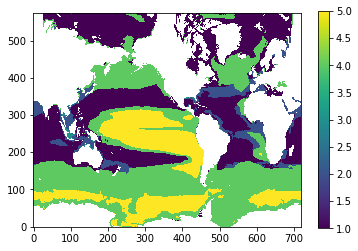

In [17]:
plt.imshow(lim_ind, origin='bottom', vmin=1,vmax=5)
plt.colorbar()

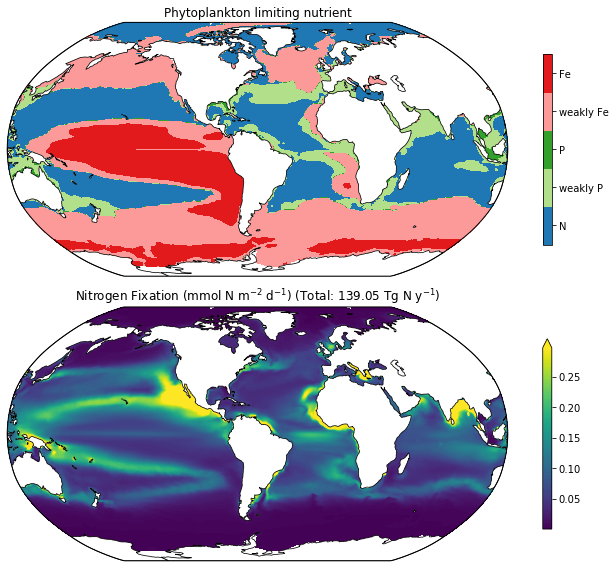

In [18]:
fig=plt.figure(figsize=(10,8))
gs=gridspec.GridSpec(2,1)

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Limiting Nutrient                                                       #
###########################################################################
levels=[0,1,2,3,4,5]

cmap = matplotlib.colors.ListedColormap(["#1F78B4","#B2DF8A","#33A02C","#FB9A99","#E31A1C"])

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=lim_ind
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels)
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Phytoplankton limiting nutrient', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0.5,1.5,2.5,3.5,4.5], shrink=0.75)
cbar.ax.set_yticklabels(['N', 'weakly P', 'P', 'weakly Fe', 'Fe'])

###########################################################################
# N-fixation                                                              #
###########################################################################
cmin = 0; cmax = 0.3; cint = 0.0025
levels=np.arange(cmin,cmax,cint)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=dsa.intpn2 * 86400 * 1e3
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='max')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Nitrogen Fixation (mmol N m$^{-2}$ d$^{-1}$) (Total: '+str(np.round(totNfix,2))+' Tg N y$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0.05,0.1,0.15,0.2,0.25,0.3], shrink=0.75)

plt.tight_layout()
fname = 'NPP_limitation_Nfix'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')